# Correlate CLIP vs DINO Individual Subject RDMs

This notebook correlates individual subject RDMs generated using CLIP embeddings vs DINO embeddings.

## Overview

This analysis:
1. Loads RDMs from both `individual_subject_rdms_clip` and `individual_subject_rdms_dinov3`
2. For each subject, computes correlation between CLIP and DINO RDMs
3. Uses only common categories present in both RDMs
4. Visualizes correlation results

## Key Features

- **Handles missing categories**: Uses only categories present in both RDMs
- **Preserves category order**: Maintains predefined category ordering for consistency
- **Robust to outliers**: Spearman correlation is less sensitive to extreme values
- **Multiple correlation metrics**: Computes both Spearman (rank-based) and Pearson (linear) correlations

## Setup and Imports

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from scipy.stats import spearmanr, pearsonr
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 150

print("All imports successful!")

All imports successful!


## Helper Functions

In [2]:
def compute_rdm_correlation(rdm1, rdm2, ordered_categories_list, available_cats1, available_cats2):
    """
    Compute correlation between two RDMs that use the full ordered_categories list with NaN for missing categories.
    Only uses categories present in both RDMs (non-NaN in both).
    
    Args:
        rdm1: numpy array of shape (n_categories, n_categories) with NaN for missing categories
        rdm2: numpy array of shape (n_categories, n_categories) with NaN for missing categories
        ordered_categories_list: full list of categories in order (used for indexing)
        available_cats1: list of categories actually present in rdm1
        available_cats2: list of categories actually present in rdm2
    
    Returns:
        corr_spearman: Spearman correlation coefficient (or np.nan if insufficient data)
        corr_pearson: Pearson correlation coefficient (or np.nan if insufficient data)
        n_common: number of common categories
    """
    # Find common categories (categories present in both RDMs)
    # IMPORTANT: Preserve predefined order from ordered_categories_list, NOT alphabetical order
    common_categories = [cat for cat in ordered_categories_list 
                        if cat in available_cats1 and cat in available_cats2]
    
    if len(common_categories) < 2:
        return np.nan, np.nan, len(common_categories)
    
    # Get indices for common categories in the ordered_categories_list
    common_indices = [ordered_categories_list.index(cat) for cat in common_categories]
    
    # Extract submatrices for common categories
    rdm1_subset = rdm1[np.ix_(common_indices, common_indices)]
    rdm2_subset = rdm2[np.ix_(common_indices, common_indices)]
    
    # Get upper triangle (excluding diagonal) for both RDMs
    mask = np.triu(np.ones_like(rdm1_subset, dtype=bool), k=1)
    rdm1_flat = rdm1_subset[mask]
    rdm2_flat = rdm2_subset[mask]
    
    # Filter out NaN values (shouldn't be any if categories are truly common, but check anyway)
    valid_mask = ~(np.isnan(rdm1_flat) | np.isnan(rdm2_flat))
    rdm1_valid = rdm1_flat[valid_mask]
    rdm2_valid = rdm2_flat[valid_mask]
    
    # Compute correlations
    if len(rdm1_valid) > 0:
        corr_spearman, _ = spearmanr(rdm1_valid, rdm2_valid)
        corr_pearson, _ = pearsonr(rdm1_valid, rdm2_valid)
        return corr_spearman, corr_pearson, len(common_categories)
    else:
        return np.nan, np.nan, len(common_categories)


def get_available_categories_from_rdm(rdm_df):
    """
    Extract available categories from an RDM DataFrame.
    A category is available if it has at least one non-NaN value in its row or column.
    
    Args:
        rdm_df: DataFrame with categories as index and columns
    
    Returns:
        list of available category names
    """
    # Check which categories have at least one non-NaN value
    # (either in their row or column, excluding diagonal)
    available = []
    for cat in rdm_df.index:
        # Check row (excluding diagonal)
        row_values = rdm_df.loc[cat, :].drop(cat)
        # Check column (excluding diagonal)
        col_values = rdm_df.loc[:, cat].drop(cat)
        # If either has non-NaN values, category is available
        if not (row_values.isna().all() and col_values.isna().all()):
            available.append(cat)
    return available

print("Helper functions loaded!")

Helper functions loaded!


## Configuration

Set up paths to CLIP and DINO RDM directories.

In [3]:
# Paths
clip_dir = Path("individual_subject_rdms_clip")
dino_dir = Path("individual_subject_rdms_dinov3")
output_dir = Path("clip_dino_rdm_correlations")
output_dir.mkdir(exist_ok=True, parents=True)

# Check if directories exist
if not clip_dir.exists():
    raise FileNotFoundError(f"CLIP RDM directory not found: {clip_dir}")
if not dino_dir.exists():
    raise FileNotFoundError(f"DINO RDM directory not found: {dino_dir}")

print(f"CLIP RDM directory: {clip_dir}")
print(f"DINO RDM directory: {dino_dir}")
print(f"Output directory: {output_dir}")

CLIP RDM directory: individual_subject_rdms_clip
DINO RDM directory: individual_subject_rdms_dinov3
Output directory: clip_dino_rdm_correlations


## Load Subject IDs and Category Order

In [4]:
# Get all subject IDs from CLIP directory
# Filter to only standard RDMs (not intersection threshold ones)
clip_csv_dir = clip_dir / "csv"

clip_rdm_files = list(clip_csv_dir.glob("rdm_*.csv"))
# Filter out intersection threshold RDMs - only keep standard format: rdm_{subject_id}.csv
subject_ids = []
for f in clip_rdm_files:
    subject_id = f.stem.replace("rdm_", "")
    # Only include if it matches the standard format (no "intersection_threshold" in name)
    if "intersection_threshold" not in subject_id:
        subject_ids.append(subject_id)

subject_ids = sorted(subject_ids)
print(f"Found {len(subject_ids)} subjects with CLIP RDMs (standard format)")

# Load ordered categories from first CLIP RDM CSV (they should all have the same order)
if len(subject_ids) == 0:
    raise ValueError("No CLIP RDM files found!")

first_clip_rdm = pd.read_csv(clip_csv_dir / f"rdm_{subject_ids[0]}.csv", index_col=0)
ordered_categories = list(first_clip_rdm.index)
print(f"Loaded ordered categories: {len(ordered_categories)} categories")
print(f"First 10 categories: {ordered_categories[:10]}")

Found 31 subjects with CLIP RDMs (standard format)
Loaded ordered categories: 163 categories
First 10 categories: ['zebra', 'giraffe', 'deer', 'pony', 'horse', 'pig', 'rooster', 'penguin', 'bird', 'duck']


## Compute Correlations

For each subject, load both CLIP and DINO RDMs and compute correlations using only common categories.

In [5]:
# Compute correlations for each subject
correlation_data = []

for subject_id in tqdm(subject_ids, desc="Computing correlations"):
    clip_csv_path = clip_csv_dir / f"rdm_{subject_id}.csv"
    dino_csv_path = dino_dir / "csv" / f"rdm_{subject_id}.csv"
    
    # Check if DINO RDM exists for this subject
    if not dino_csv_path.exists():
        print(f"Warning: DINO RDM not found for subject {subject_id}, skipping...")
        continue
    
    # Load RDMs
    clip_rdm_df = pd.read_csv(clip_csv_path, index_col=0)
    dino_rdm_df = pd.read_csv(dino_csv_path, index_col=0)
    
    # Reorder to match ordered_categories if needed
    # This handles cases where category order might differ
    clip_categories = list(clip_rdm_df.index)
    dino_categories = list(dino_rdm_df.index)
    
    # Check if reordering is needed
    if clip_categories != ordered_categories:
        # Reorder CLIP RDM to match ordered_categories
        missing_cats = set(ordered_categories) - set(clip_categories)
        if missing_cats:
            print(f"Warning: Subject {subject_id} CLIP RDM missing categories: {missing_cats}")
        # Reorder and add NaN rows/columns for missing categories
        clip_rdm_df = clip_rdm_df.reindex(index=ordered_categories, columns=ordered_categories)
    
    if dino_categories != ordered_categories:
        # Reorder DINO RDM to match ordered_categories
        missing_cats = set(ordered_categories) - set(dino_categories)
        if missing_cats:
            print(f"Warning: Subject {subject_id} DINO RDM missing categories: {missing_cats}")
        # Reorder and add NaN rows/columns for missing categories
        dino_rdm_df = dino_rdm_df.reindex(index=ordered_categories, columns=ordered_categories)
    
    # Convert to numpy arrays
    clip_rdm = clip_rdm_df.values
    dino_rdm = dino_rdm_df.values
    
    # Get available categories
    clip_available = get_available_categories_from_rdm(clip_rdm_df)
    dino_available = get_available_categories_from_rdm(dino_rdm_df)
    
    # Compute correlation
    corr_spearman, corr_pearson, n_common = compute_rdm_correlation(
        clip_rdm, dino_rdm,
        ordered_categories,
        clip_available,
        dino_available
    )
    
    correlation_data.append({
        'subject_id': subject_id,
        'spearman_correlation': corr_spearman,
        'pearson_correlation': corr_pearson,
        'n_common_categories': n_common,
        'n_clip_categories': len(clip_available),
        'n_dino_categories': len(dino_available),
    })

print(f"\nComputed correlations for {len(correlation_data)} subjects")

Computing correlations: 100%|██████████| 31/31 [00:04<00:00,  7.74it/s]


Computed correlations for 31 subjects


## Save Results

In [6]:
# Create DataFrame and save
results_df = pd.DataFrame(correlation_data)
results_df = results_df.sort_values('subject_id')

output_csv = output_dir / "clip_dino_rdm_correlations.csv"
results_df.to_csv(output_csv, index=False)

print(f"Results saved to: {output_csv}")
print(f"\n{'='*60}")
print("CORRELATION RESULTS SUMMARY")
print(f"{'='*60}")
print(f"Total subjects analyzed: {len(results_df)}")
print(f"\nSpearman Correlation:")
print(f"  Mean: {results_df['spearman_correlation'].mean():.4f}")
print(f"  Std:  {results_df['spearman_correlation'].std():.4f}")
print(f"  Min:  {results_df['spearman_correlation'].min():.4f}")
print(f"  Max:  {results_df['spearman_correlation'].max():.4f}")
print(f"\nPearson Correlation:")
print(f"  Mean: {results_df['pearson_correlation'].mean():.4f}")
print(f"  Std:  {results_df['pearson_correlation'].std():.4f}")
print(f"  Min:  {results_df['pearson_correlation'].min():.4f}")
print(f"  Max:  {results_df['pearson_correlation'].max():.4f}")
print(f"\nCommon Categories:")
print(f"  Mean: {results_df['n_common_categories'].mean():.1f}")
print(f"  Std:  {results_df['n_common_categories'].std():.1f}")
print(f"  Min:  {results_df['n_common_categories'].min()}")
print(f"  Max:  {results_df['n_common_categories'].max()}")

# Display first few rows
print(f"\nFirst 5 rows of results:")
display(results_df.head())

Results saved to: clip_dino_rdm_correlations/clip_dino_rdm_correlations.csv

CORRELATION RESULTS SUMMARY
Total subjects analyzed: 31

Spearman Correlation:
  Mean: 0.8520
  Std:  0.0393
  Min:  0.7489
  Max:  0.9036

Pearson Correlation:
  Mean: 0.8680
  Std:  0.0349
  Min:  0.7799
  Max:  0.9129

Common Categories:
  Mean: 148.3
  Std:  16.8
  Min:  99
  Max:  162

First 5 rows of results:


,subject_id,spearman_correlation,pearson_correlation,n_common_categories,n_clip_categories,n_dino_categories
0,00220001,0.853162,0.862001,155,155,155
1,00230001,0.842338,0.861272,143,143,143
2,00240001,0.881615,0.887801,159,159,159
3,00320001,0.875049,0.893079,162,162,162
4,00320002,0.898453,0.908260,156,156,156


## Visualize Results

Create visualizations of the correlation results.

Saved visualization to: clip_dino_rdm_correlations/clip_dino_correlation_visualization.png
Saved visualization (PDF) to: clip_dino_rdm_correlations/clip_dino_correlation_visualization.pdf


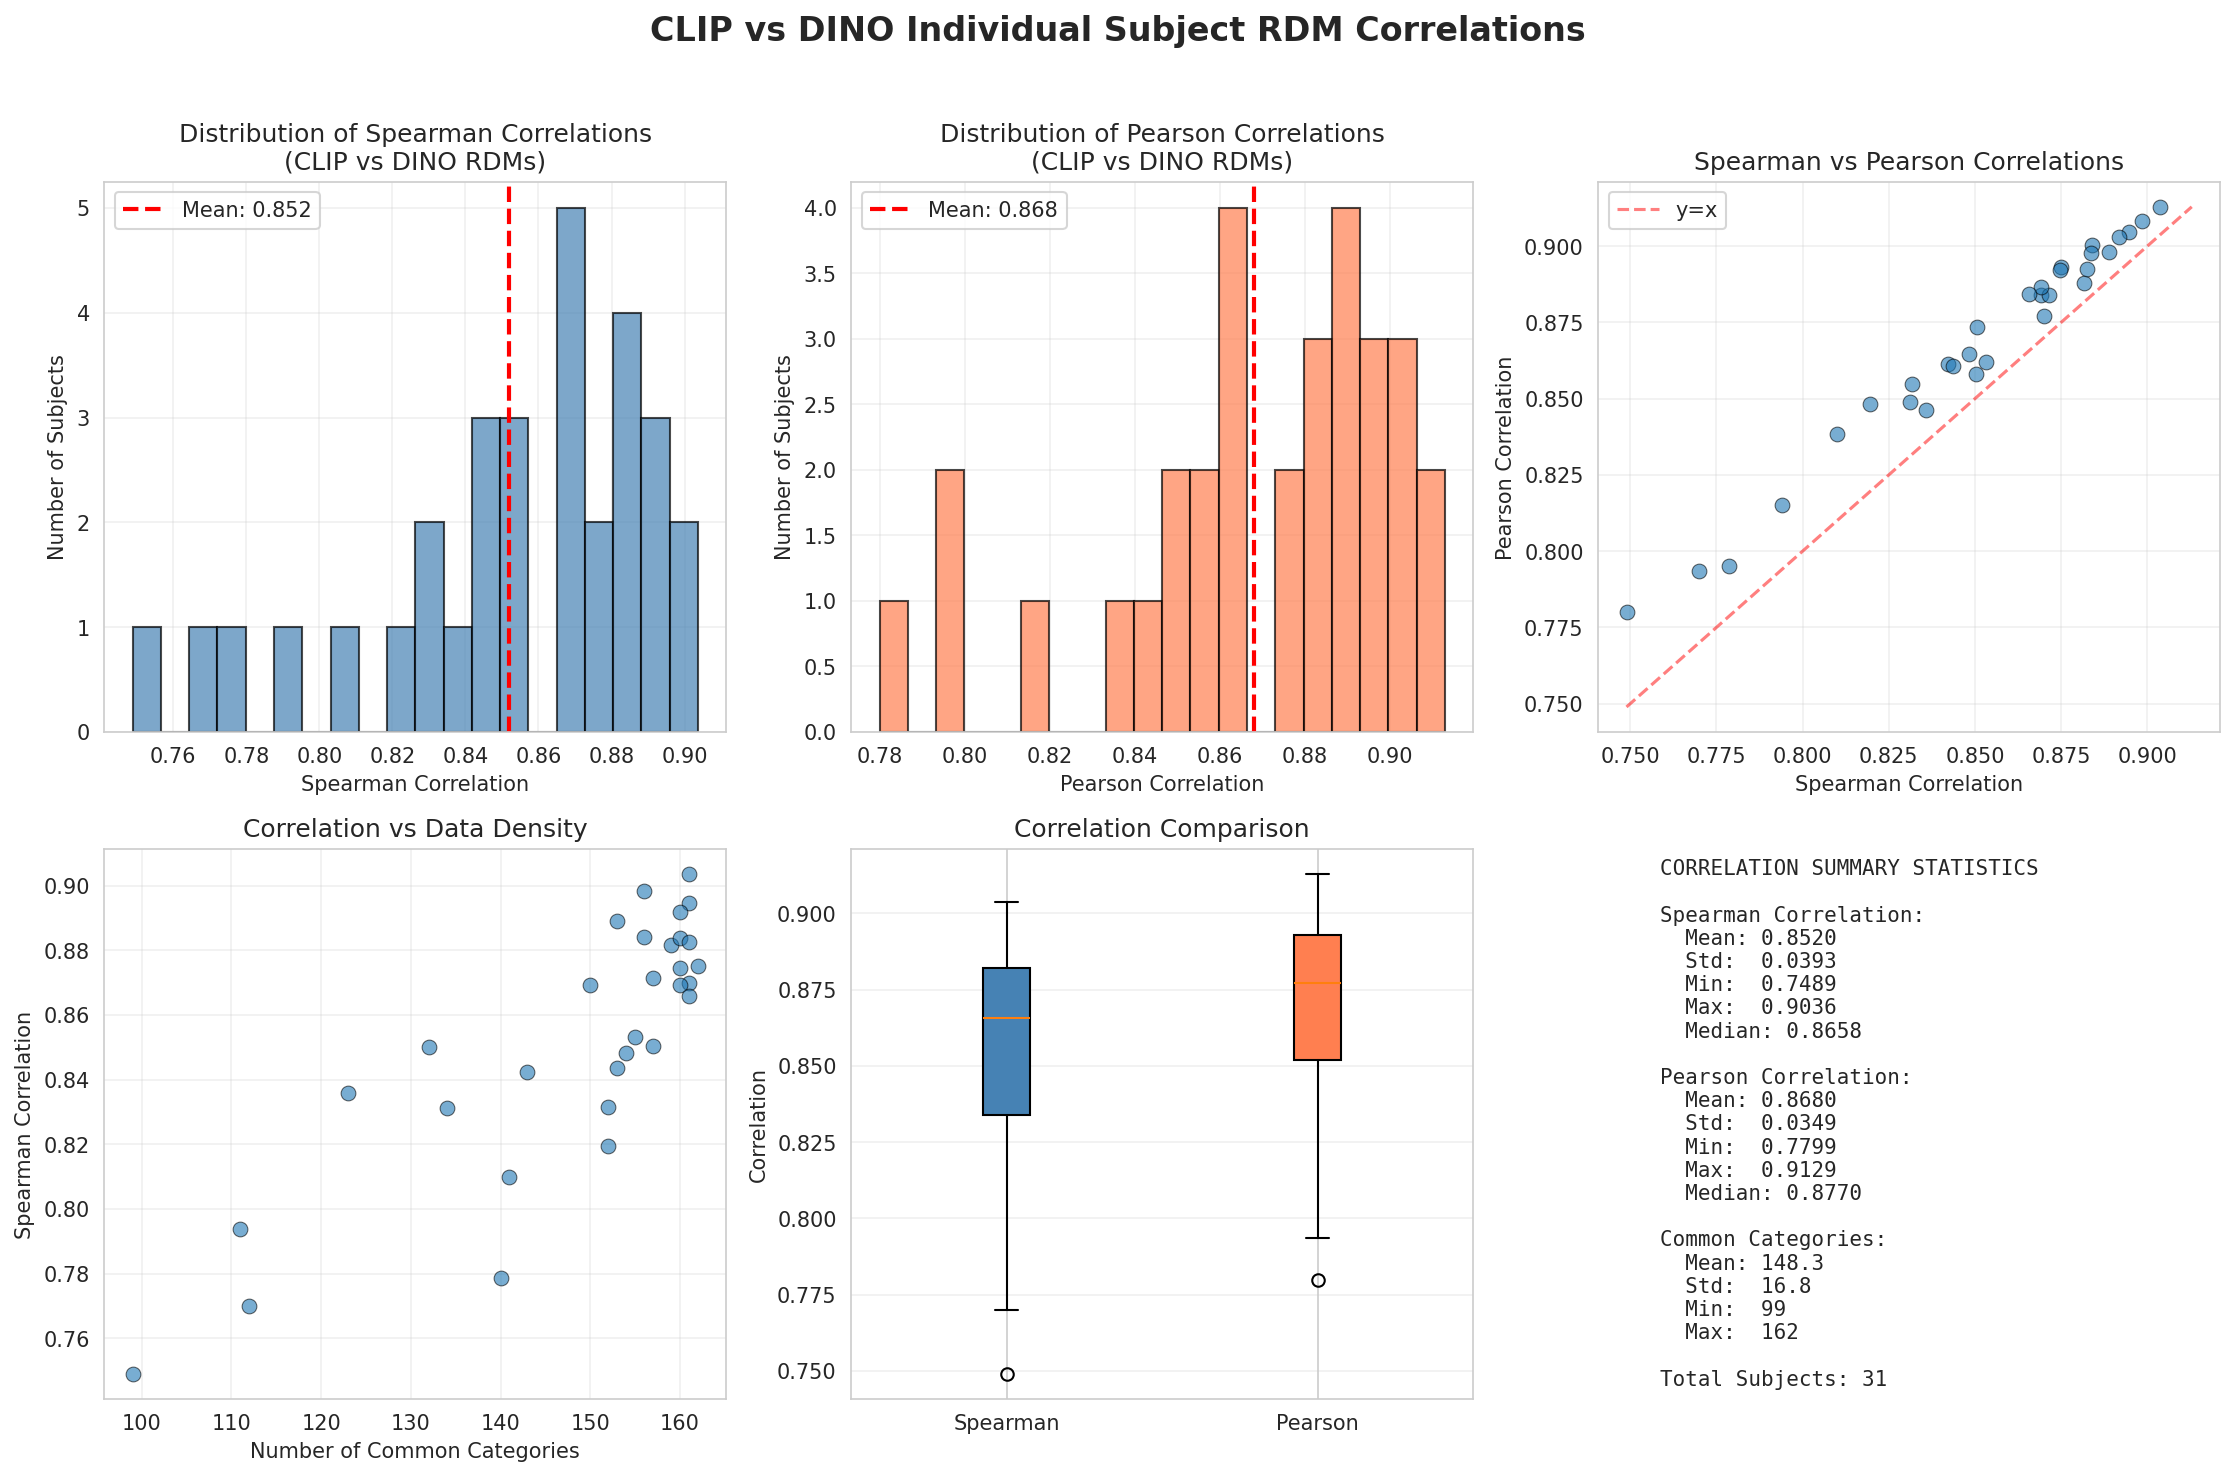

In [7]:
# Create figure with subplots
fig = plt.figure(figsize=(15, 10))

# 1. Histogram of Spearman correlations
ax1 = plt.subplot(2, 3, 1)
ax1.hist(results_df['spearman_correlation'], bins=20, edgecolor='black', alpha=0.7, color='steelblue')
ax1.axvline(results_df['spearman_correlation'].mean(), color='red', linestyle='--', 
            linewidth=2, label=f'Mean: {results_df["spearman_correlation"].mean():.3f}')
ax1.set_xlabel('Spearman Correlation')
ax1.set_ylabel('Number of Subjects')
ax1.set_title('Distribution of Spearman Correlations\n(CLIP vs DINO RDMs)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Histogram of Pearson correlations
ax2 = plt.subplot(2, 3, 2)
ax2.hist(results_df['pearson_correlation'], bins=20, edgecolor='black', alpha=0.7, color='coral')
ax2.axvline(results_df['pearson_correlation'].mean(), color='red', linestyle='--', 
            linewidth=2, label=f'Mean: {results_df["pearson_correlation"].mean():.3f}')
ax2.set_xlabel('Pearson Correlation')
ax2.set_ylabel('Number of Subjects')
ax2.set_title('Distribution of Pearson Correlations\n(CLIP vs DINO RDMs)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Scatter plot: Spearman vs Pearson
ax3 = plt.subplot(2, 3, 3)
ax3.scatter(results_df['spearman_correlation'], results_df['pearson_correlation'], 
            alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
# Add diagonal line
min_val = min(results_df['spearman_correlation'].min(), results_df['pearson_correlation'].min())
max_val = max(results_df['spearman_correlation'].max(), results_df['pearson_correlation'].max())
ax3.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.5, label='y=x')
ax3.set_xlabel('Spearman Correlation')
ax3.set_ylabel('Pearson Correlation')
ax3.set_title('Spearman vs Pearson Correlations')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Correlation vs number of common categories
ax4 = plt.subplot(2, 3, 4)
ax4.scatter(results_df['n_common_categories'], results_df['spearman_correlation'], 
            alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
ax4.set_xlabel('Number of Common Categories')
ax4.set_ylabel('Spearman Correlation')
ax4.set_title('Correlation vs Data Density')
ax4.grid(True, alpha=0.3)

# 5. Box plot comparing Spearman and Pearson
ax5 = plt.subplot(2, 3, 5)
data_to_plot = [results_df['spearman_correlation'], results_df['pearson_correlation']]
bp = ax5.boxplot(data_to_plot, tick_labels=['Spearman', 'Pearson'], patch_artist=True)
bp['boxes'][0].set_facecolor('steelblue')
bp['boxes'][1].set_facecolor('coral')
ax5.set_ylabel('Correlation')
ax5.set_title('Correlation Comparison')
ax5.grid(True, alpha=0.3, axis='y')

# 6. Summary statistics text
ax6 = plt.subplot(2, 3, 6)
ax6.axis('off')

summary_text = f"""
CORRELATION SUMMARY STATISTICS

Spearman Correlation:
  Mean: {results_df['spearman_correlation'].mean():.4f}
  Std:  {results_df['spearman_correlation'].std():.4f}
  Min:  {results_df['spearman_correlation'].min():.4f}
  Max:  {results_df['spearman_correlation'].max():.4f}
  Median: {results_df['spearman_correlation'].median():.4f}

Pearson Correlation:
  Mean: {results_df['pearson_correlation'].mean():.4f}
  Std:  {results_df['pearson_correlation'].std():.4f}
  Min:  {results_df['pearson_correlation'].min():.4f}
  Max:  {results_df['pearson_correlation'].max():.4f}
  Median: {results_df['pearson_correlation'].median():.4f}

Common Categories:
  Mean: {results_df['n_common_categories'].mean():.1f}
  Std:  {results_df['n_common_categories'].std():.1f}
  Min:  {results_df['n_common_categories'].min()}
  Max:  {results_df['n_common_categories'].max()}

Total Subjects: {len(results_df)}
"""

ax6.text(0.1, 0.5, summary_text, fontsize=10, family='monospace',
         verticalalignment='center', horizontalalignment='left')

plt.suptitle('CLIP vs DINO Individual Subject RDM Correlations', 
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Save figure
output_path = output_dir / "clip_dino_correlation_visualization.png"
plt.savefig(output_path, dpi=200, bbox_inches='tight')
print(f"Saved visualization to: {output_path}")

# Also save as PDF
output_path_pdf = output_dir / "clip_dino_correlation_visualization.pdf"
plt.savefig(output_path_pdf, bbox_inches='tight')
print(f"Saved visualization (PDF) to: {output_path_pdf}")

plt.show()